# CNN pruning and quantization




Quantization allows for decreasing data memory size necessary to store them.

Also allows for faster computation with dedicated devices like embedded GPU and FPGA.

Applying quantization on continues data creates regions of attraction.

Values from some range are assigned to proper value that represents that range.

That also increase the level of correlation between quantized filters, 

so allows for more effective pruning.

That results with much more smaller network than at the beginning.  

In [1]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [31]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict
from copy import deepcopy

# local_utils file contains util functions for training or display
# CHECK IT
import local_utils as lu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def set_random_seed(seed:int = 0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    

cuda


Datasets

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

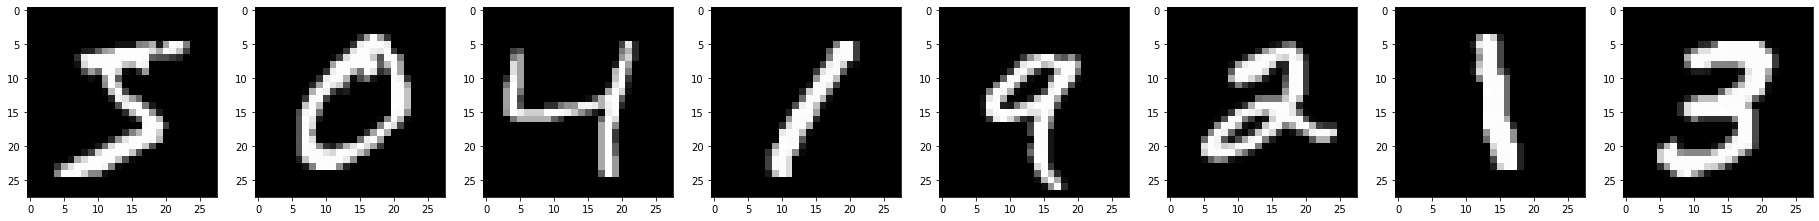

In [2]:
from torchvision.transforms import ToTensor

BATCH_SIZE = 64
set_random_seed(0)

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=ToTensor())
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 1, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.permute(1,2,0))
    plt.show()
    break

Network definition and training

Run network training - it spends very long time, so for only your code check you can run only one epoch.

When you check your code back to 30 epochs :) .

In [50]:
from brevitas.nn import QuantConv2d, QuantIdentity
from brevitas.quant.scaled_int import Int8WeightPerTensorFloat, \
    Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28), 
                 num_of_classes=10,
                 channels = [16,32,64,128], # number of conv filters 
                 ksize   =  [3, 3, 3, 3], # kernels sizes
                 padding =  [1, 1, 0, 0], # padding sizes
                 max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                 quantize=True,
                 bit_width=4
                 ) -> None:
        super().__init__()
        channels = [input_shape[0]]+channels
        padding = [1,1,0,0]
        max_pool = [1,1,0,0]
        
        if quantize:
            input_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
        else:
            input_quant = QuantIdentity(None)
        
        layers = []
        self.conv_layers = []
        map_shape = [input_shape[0],input_shape[1],input_shape[2]]
        for i, (ch_in, ch_out, ks, p, mp) in enumerate(zip(channels[:-1],
                                                       channels[1:],
                                                       ksize,
                                                       padding,
                                                       max_pool)):
            conv = QuantConv2d(ch_in, ch_out, ks, padding=p, bias=True, 
                               weight_quant=Int8WeightPerTensorFloat if quantize else None,
                               bias_quant=Int8BiasPerTensorFloatInternalScaling if quantize else None,
                               weight_bit_width=bit_width,
                               bias_bit_width=bit_width,
                               return_quant_tensor=False
                               )
            # shape modification
            map_shape[0] = ch_out
            map_shape[1] = map_shape[1] - 2*(ks//2 - p)
            map_shape[2] = map_shape[2] - 2*(ks//2 - p)
            
            # store conv layers for further analysis and prunning
            self.conv_layers.append(conv)
            # add to all layers
            layers.append(conv)
            
            if quantize:
                out_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
            else:
                out_quant = QuantIdentity(None)
            
            layers.append(out_quant)
            relu = nn.ReLU()
            layers.append(relu)
            
            if mp:
                maxpool = nn.MaxPool2d(2,2)
                # shape modification
                map_shape[1] = map_shape[1] // 2
                map_shape[2] = map_shape[2] // 2
                layers.append(maxpool)
        
        self.CNN = nn.Sequential(input_quant, *tuple(layers))
        
        CNN_flatten_len = torch.prod(torch.tensor(map_shape))
        print(f"CNN out map shape = {map_shape}")
        print(f"CNN out map numel = {CNN_flatten_len}")
        self.flatten = nn.Flatten()
        self.FC = nn.Linear(CNN_flatten_len, num_of_classes)
        self.sm = nn.Softmax(1)
    
    def forward(self, x: torch.Tensor):
        x = self.CNN(x)
        x = self.flatten(x)
        x = self.FC(x)
        x = self.sm(x)
        return x

set_random_seed(0)
net = NeuralNetwork(input_shape=(1,28,28), 
                    num_of_classes=10,
                    channels = [32,32,32,32], # number of conv filters 
                    ksize   =  [3, 3, 3, 3], # kernels sizes
                    padding =  [1, 1, 0, 0], # padding sizes
                    max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                    quantize=True
                    ).to(device)
net_param_number = lu.count_params(net)
print(f"Network paramerters number: {net_param_number}")

set_random_seed(0)
metric = lu.AccuracyMetic()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.8, weight_decay=0.0001)

set_random_seed(0)
net, history = lu.training(net, train_loader, test_loader, criterion, metric, optimizer, 5, 30, device=device)

CNN out map shape = [256, 3, 3]
CNN out map numel = 2304
Network paramerters number: 115855
Epoch 1 / 30: STARTED
TRAINING

938it [00:55, 17.03it/s]


VALIDATION

157it [00:07, 19.99it/s]


After epoch 1: loss=2.1452 acc=0.3088 val_loss=1.8961 val_acc=0.5638
Epoch 1 / 30: FINISHED

Epoch 2 / 30: STARTED
TRAINING

938it [00:47, 19.84it/s]


VALIDATION

157it [00:07, 19.76it/s]


After epoch 2: loss=1.7564 acc=0.7033 val_loss=1.6876 val_acc=0.7726
Epoch 2 / 30: FINISHED

Epoch 3 / 30: STARTED
TRAINING

938it [00:47, 19.90it/s]


VALIDATION

157it [00:07, 19.89it/s]


After epoch 3: loss=1.6824 acc=0.7778 val_loss=1.6676 val_acc=0.7926
Epoch 3 / 30: FINISHED

Epoch 4 / 30: STARTED
TRAINING

938it [00:46, 19.96it/s]


VALIDATION

157it [00:07, 19.94it/s]


After epoch 4: loss=1.6182 acc=0.8423 val_loss=1.5809 val_acc=0.8794
Epoch 4 / 30: FINISHED

Epoch 5 / 30: STARTED
TRAINING

938it [00:47, 19.79it/s]


VALIDATION

157it [00:07, 19.74it/s]


After epoch 5: loss=1.5847 acc=0.8754 val_loss=1.5774 val_acc=0.8823
Epoch 5 / 30: FINISHED

Epoch 6 / 30: STARTED
TRAINING

938it [00:47, 19.87it/s]


VALIDATION

157it [00:07, 19.87it/s]


After epoch 6: loss=1.5792 acc=0.8807 val_loss=1.5754 val_acc=0.8841
Epoch 6 / 30: FINISHED

Epoch 7 / 30: STARTED
TRAINING

938it [00:47, 19.78it/s]


VALIDATION

157it [00:07, 19.76it/s]


After epoch 7: loss=1.5758 acc=0.8835 val_loss=1.5732 val_acc=0.8858
Epoch 7 / 30: FINISHED

Epoch 8 / 30: STARTED
TRAINING

938it [00:47, 19.84it/s]


VALIDATION

157it [00:07, 19.72it/s]


After epoch 8: loss=1.5724 acc=0.8861 val_loss=1.5716 val_acc=0.8864
Epoch 8 / 30: FINISHED

Epoch 9 / 30: STARTED
TRAINING

938it [00:47, 19.80it/s]


VALIDATION

157it [00:07, 19.72it/s]


After epoch 9: loss=1.5714 acc=0.8870 val_loss=1.5720 val_acc=0.8865
Epoch 9 / 30: FINISHED

Epoch 10 / 30: STARTED
TRAINING

938it [00:47, 19.76it/s]


VALIDATION

157it [00:07, 19.71it/s]


After epoch 10: loss=1.5702 acc=0.8881 val_loss=1.5704 val_acc=0.8879
Epoch 10 / 30: FINISHED

Epoch 11 / 30: STARTED
TRAINING

938it [00:47, 19.81it/s]


VALIDATION

157it [00:08, 19.57it/s]


After epoch 11: loss=1.5402 acc=0.9190 val_loss=1.4809 val_acc=0.9809
Epoch 11 / 30: FINISHED

Epoch 12 / 30: STARTED
TRAINING

938it [00:47, 19.68it/s]


VALIDATION

157it [00:07, 19.67it/s]


After epoch 12: loss=1.4746 acc=0.9871 val_loss=1.4753 val_acc=0.9860
Epoch 12 / 30: FINISHED

Epoch 13 / 30: STARTED
TRAINING

938it [00:49, 19.11it/s]


VALIDATION

157it [00:07, 19.66it/s]


After epoch 13: loss=1.4720 acc=0.9896 val_loss=1.4772 val_acc=0.9845
Epoch 13 / 30: FINISHED

Epoch 14 / 30: STARTED
TRAINING

938it [00:49, 19.11it/s]


VALIDATION

157it [00:08, 19.49it/s]


After epoch 14: loss=1.4706 acc=0.9911 val_loss=1.4749 val_acc=0.9864
Epoch 14 / 30: FINISHED

Epoch 15 / 30: STARTED
TRAINING

938it [00:47, 19.62it/s]


VALIDATION

157it [00:07, 20.03it/s]


After epoch 15: loss=1.4706 acc=0.9910 val_loss=1.4769 val_acc=0.9844
Epoch 15 / 30: FINISHED

Epoch 16 / 30: STARTED
TRAINING

938it [00:47, 19.55it/s]


VALIDATION

157it [00:08, 19.43it/s]


After epoch 16: loss=1.4696 acc=0.9919 val_loss=1.4737 val_acc=0.9878
Epoch 16 / 30: FINISHED

Epoch 17 / 30: STARTED
TRAINING

938it [00:48, 19.45it/s]


VALIDATION

157it [00:07, 19.75it/s]


After epoch 17: loss=1.4690 acc=0.9926 val_loss=1.4731 val_acc=0.9878
Epoch 17 / 30: FINISHED

Epoch 18 / 30: STARTED
TRAINING

938it [00:49, 18.80it/s]


VALIDATION

157it [00:08, 19.16it/s]


After epoch 18: loss=1.4686 acc=0.9929 val_loss=1.4749 val_acc=0.9859
Epoch 18 / 30: FINISHED

Epoch 19 / 30: STARTED
TRAINING

938it [00:45, 20.81it/s]


VALIDATION

157it [00:08, 17.94it/s]


After epoch 19: loss=1.4680 acc=0.9936 val_loss=1.4744 val_acc=0.9869
Epoch 19 / 30: FINISHED

Epoch 20 / 30: STARTED
TRAINING

938it [00:47, 19.74it/s]


VALIDATION

157it [00:07, 20.13it/s]


After epoch 20: loss=1.4676 acc=0.9938 val_loss=1.4714 val_acc=0.9901
Epoch 20 / 30: FINISHED

Epoch 21 / 30: STARTED
TRAINING

938it [00:46, 20.25it/s]


VALIDATION

157it [00:07, 19.94it/s]


After epoch 21: loss=1.4673 acc=0.9941 val_loss=1.4723 val_acc=0.9890
Epoch 21 / 30: FINISHED

Epoch 22 / 30: STARTED
TRAINING

938it [00:46, 20.07it/s]


VALIDATION

157it [00:07, 19.96it/s]


After epoch 22: loss=1.4668 acc=0.9947 val_loss=1.4708 val_acc=0.9906
Epoch 22 / 30: FINISHED

Epoch 23 / 30: STARTED
TRAINING

938it [00:47, 19.95it/s]


VALIDATION

157it [00:07, 20.05it/s]


After epoch 23: loss=1.4664 acc=0.9951 val_loss=1.4712 val_acc=0.9900
Epoch 23 / 30: FINISHED

Epoch 24 / 30: STARTED
TRAINING

938it [00:46, 19.98it/s]


VALIDATION

157it [00:07, 20.08it/s]


After epoch 24: loss=1.4663 acc=0.9952 val_loss=1.4717 val_acc=0.9894
Epoch 24 / 30: FINISHED

Epoch 25 / 30: STARTED
TRAINING

938it [00:47, 19.82it/s]


VALIDATION

157it [00:07, 19.93it/s]


After epoch 25: loss=1.4658 acc=0.9957 val_loss=1.4714 val_acc=0.9899
Epoch 25 / 30: FINISHED

Epoch 26 / 30: STARTED
TRAINING

938it [00:47, 19.94it/s]


VALIDATION

157it [00:07, 19.88it/s]


After epoch 26: loss=1.4653 acc=0.9961 val_loss=1.4708 val_acc=0.9907
Epoch 26 / 30: FINISHED

Epoch 27 / 30: STARTED
TRAINING

938it [00:47, 19.69it/s]


VALIDATION

157it [00:08, 19.38it/s]


After epoch 27: loss=1.4654 acc=0.9961 val_loss=1.4720 val_acc=0.9895
Epoch 27 / 30: FINISHED

Epoch 28 / 30: STARTED
TRAINING

938it [00:47, 19.69it/s]


VALIDATION

157it [00:07, 19.98it/s]


After epoch 28: loss=1.4651 acc=0.9964 val_loss=1.4701 val_acc=0.9915
Epoch 28 / 30: FINISHED

Epoch 29 / 30: STARTED
TRAINING

938it [00:47, 19.87it/s]


VALIDATION

157it [00:07, 19.71it/s]


After epoch 29: loss=1.4644 acc=0.9971 val_loss=1.4710 val_acc=0.9907
Epoch 29 / 30: FINISHED

Epoch 30 / 30: STARTED
TRAINING

938it [00:47, 19.81it/s]


VALIDATION

157it [00:07, 19.73it/s]

After epoch 30: loss=1.4645 acc=0.9970 val_loss=1.4698 val_acc=0.9916
Epoch 30 / 30: FINISHED



1. Extract state dict from each conv layer (`net.conv_layers` is a list of Conv2d submodules) and store it in a list `state_dicts_float`.

Create second list `state_dicts_quant` with the same structure, 

but extract weights and biases after applied quantization (`.quant_weight()`, `.quant_bias()` -> `QuantTensor` - extract float tensor from it).

Also create `state_dicts_quant_2` as a copy of `state_dicts_quant` elements - deep copy.

Print layer index (in list) and shapes of weights and biases.

Extract state dict of FC subnetwork. 
Store it as `sd_fc` and copy to `sd_fc_2`. 
Print weight and bias shapes for FC layer.


Compare (display Sum of Absolute Difference value) weight for first convolution before(float) and after quantization.

Note: state dict of Conv2d and QuantConv2d contains: `weight` and `bias` (optional) keys only.

Remember about `torch.no_grad()` context

In [ ]:

state_dicts_float: List[Dict[str, torch.Tensor]] = []
state_dicts_quant: List[Dict[str, torch.Tensor]] = []
state_dicts_quant_2: List[Dict[str, torch.Tensor]] = []
sd_fc = None
sd_fc_2 = None

with torch.no_grad():
    for i, L in enumerate(net.conv_layers):
        L: QuantConv2d = L
        ...
...

In [52]:
def get_mask(parameter: torch.Tensor, threshold: float):
    """
    Function returns the mask of filters which should not be removed. 

    :param parameter: weight tensor with shape = (num_of_filters, input_channels, Optional[kernel_height, kernel_width]]
    :param threshold float: threshold value - cos of "angle" between filters 
    :return: tensor - bool mask
    """
    original_shape = parameter.shape
    parameter = parameter.reshape(original_shape[0],-1)
    parameter = parameter / (parameter.square().sum(1).reshape(-1,1).sqrt())
    
    # correlation matrix
    corr = torch.matmul(parameter, parameter.transpose(0,1))
    
    # highly correlated filters mask 
    corr_mask = corr.abs() > threshold

    # print(corr.shape)
    
    # over diagonal matrix
    row_idx, col_idx = torch.meshgrid(torch.arange(0,corr.shape[0]), torch.arange(0,corr.shape[0]),)
    analysis_mask = col_idx > row_idx
    
    # over diagonal part of mask
    filters_correlation = corr_mask * analysis_mask.to(parameter.device)

    channels_mask = filters_correlation.sum(0) == 0
    
    return channels_mask


2. Calculate pruning masks (`get_mask`) for each quantized weights from `state_dicts_quant` list.

Store them in list `masks`.

Calculate number of filters of convolutional layers after pruning for each layer

and print it.

Use thresholds for next CNN layers: `thresholds = [0.5, 0.5, 0.5, 0.5]`

Hint: work on copy of weights - `torch.Tensor.clone` 

In [53]:
masks: List[torch.Tensor] = []
num_of_filters_after_pruning = []
thresholds = [0.5, 0.5, 0.5, 0.5]

for i, (sd_q, th) in enumerate(zip(state_dicts_quant, thresholds)):
    w = sd_q['weight'].clone()
    ...
    
    masks.append(...)
    num_of_filters_after_pruning.append(...)
    
    print(f"Layer {i}: filters after pruning: {f}")

Layer 0: filters after pruning: 30
Layer 1: filters after pruning: 25
Layer 2: filters after pruning: 28
Layer 3: filters after pruning: 137


3. Slice weights and biases from `state_dicts_quant` based on created `masks`.

Results assign to proper indices and keys of `state_dicts_quant_2`.

Slice weight of fc layer from `sd_fc` and result assign to `sd_fc_2` based on last mask.

Print shapes of weights and biases.

Note: Pruning of channels one layer affects to next one layer, but not to the previous layer.

Note: bias is related with layer output channel.

Note: first layer must contain the same number of input channels.

Hint: For slicing of few dimensions, use it separately on results of previous dim slice.

Hint: Do it in loop: store mask for previous mask as variable like `prev_mask`.

For init `prev_mask` use tensor of True and shape (1,) - input channels.

Note: Fc layer is forwarded by flatten layer ((BS,CH,H,W) -> (BS, CH * H * W)), 

so the input mask should be properly modified:

```fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,H,W).flatten()```

CH,H,W sizes are printed, when the network is instantiated. 

In [54]:
prev_mask = torch.ones((1,), dtype=torch.bool, device=device)

for i, (mask, sd_q, sd_q_2) in enumerate(zip(masks, state_dicts_quant, state_dicts_quant_2)):
    ...
    
    print(f"Layer {i}: weight: {w.shape}")
    print(f"Layer {i}: bias: {b.shape}")
    prev_mask = mask.clone()

fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,3,3).flatten()

w = ...
b = ...
sd_fc_2['weight'] = ...

print(f"Layer FC: weight: {w.shape}")
print(f"Layer FC: bias: {b.shape}")

Layer 0: weight: torch.Size([30, 1, 3, 3])
Layer 0: bias: torch.Size([30])
Layer 1: weight: torch.Size([25, 30, 3, 3])
Layer 1: bias: torch.Size([25])
Layer 2: weight: torch.Size([28, 25, 3, 3])
Layer 2: bias: torch.Size([28])
Layer 3: weight: torch.Size([137, 28, 3, 3])
Layer 3: bias: torch.Size([137])
Layer FC: weight: torch.Size([10, 1233])
Layer FC: bias: torch.Size([10, 2304])


4. Instantiate second `NeuralNetwork` as `net_2` with channels number defined by `num_of_filters_after_pruning`.

Initialize conv subnetwork (`net_2.conv_layers`) with state dicts from `state_dicts_quant_2`.

Initialize FC layer with `sd_fc_2`.

Print number of parameters.

In [55]:
set_random_seed(0)
net_2 = NeuralNetwork(input_shape=(1,28,28), 
                      num_of_classes=10,
                      channels = ..., # number of conv filters 
                      ksize   =  [3, 3, 3, 3], # kernels sizes
                      padding =  [1, 1, 0, 0], # padding sizes
                      max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                      quantize=True
                      ).to(device)
...

print(f"Network parameters number: {net_2_param_number}")

CNN out map shape = [137, 3, 3]
CNN out map numel = 1233
Network parameters number: 60409


5. Calculate accuracy and loss for training and validation datasets.


In [56]:
loss, acc = lu.train_test_pass(...,
                               ...,
                               ...,
                               ...,
                               optimizer=None,
                               update_period=None,
                               mode='test',
                               device=device)[1:]
print(loss, acc)
loss, acc = lu.train_test_pass(...,
                               ...,
                               ...,
                               ...,
                               optimizer=None,
                               update_period=None,
                               mode='test',
                               device=device)[1:]
print(loss, acc)

938it [00:38, 24.23it/s]


2.157855923207601 0.8377333333333333


157it [00:06, 25.38it/s]

2.1581057594299318 0.8423


6. *Aditional: Try 5 different thresholds setting (5 lists of settings) for `get_mask` function.

Print resulted sizes.

9. **Additional: Fine tune pruned model (`net_2`) - train it.

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.